In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [42]:
#dados fictícios
data = pd.DataFrame({
    'Data': pd.date_range(start='2023-01-01', periods=365, freq='D'),
    'Preço': [10.99] * 100 + [11.99] * 100 + [12.99] * 165,
    'Quantidade_estoque': [200 - 2 * i for i in range(365)],
    'Promoção': [0, 0, 1, 0, 0, 0, 1] * 52 + [0],
    'Dia_da_semana': [i % 7 for i in range(365)],
    'Mês': [((i // 30) % 12) + 1 for i in range(365)],
    'Estação': ['Verão'] * 90 + ['Outono'] * 90 + ['Inverno'] * 90 + ['Primavera'] * 95,
    'Vendas': [30, 28, 40, 25, 20, 22, 35] * 52 + [15]
})

#'data' para datetime
data['Data'] = pd.to_datetime(data['Data'])
data.set_index('Data', inplace=True)

data


,Preço,Quantidade_estoque,Promoção,Dia_da_semana,Mês,Estação,Vendas
Data,,,,,,,
2023-01-01,10.99,200,0,0,1,Verão,30
2023-01-02,10.99,198,0,1,1,Verão,28
2023-01-03,10.99,196,1,2,1,Verão,40
2023-01-04,10.99,194,0,3,1,Verão,25
2023-01-05,10.99,192,0,4,1,Verão,20
...,...,...,...,...,...,...,...
2023-12-27,12.99,-520,0,3,1,Primavera,25
2023-12-28,12.99,-522,0,4,1,Primavera,20
2023-12-29,12.99,-524,0,5,1,Primavera,22


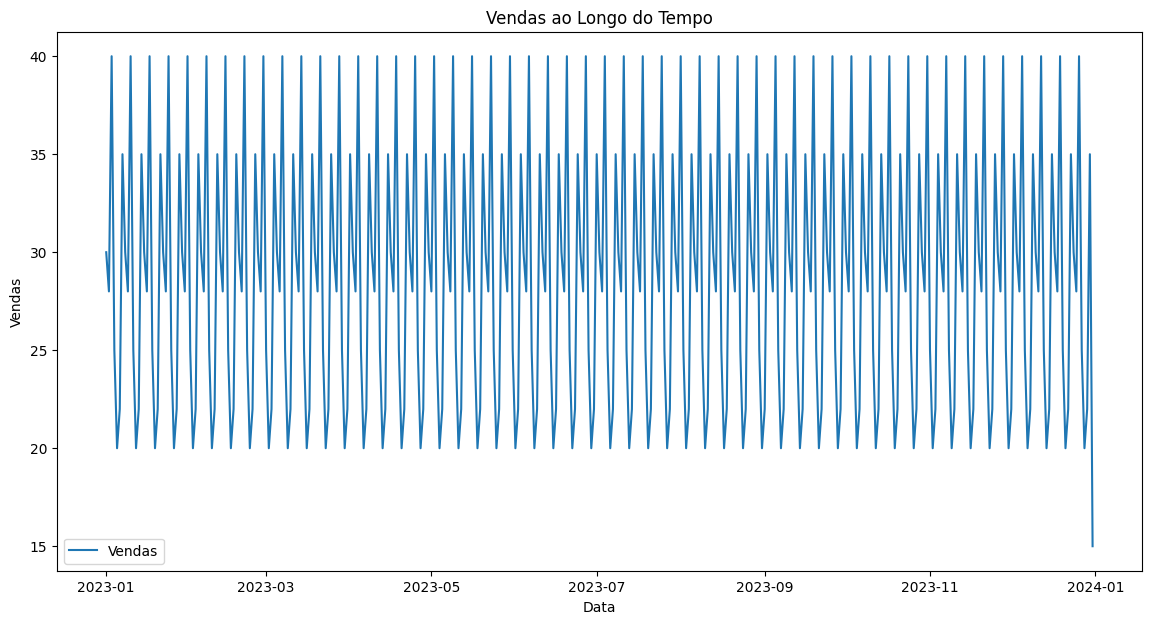

In [43]:
#gráfico da serie

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Vendas'], label='Vendas')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Vendas ao Longo do Tempo')
plt.legend()
plt.show()

<Figure size 1400x700 with 0 Axes>

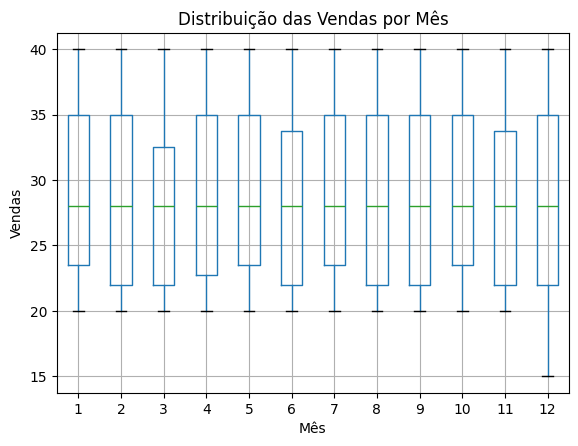

In [44]:
#vendas por mês
plt.figure(figsize=(14, 7))
data['Mês'] = data.index.month
data.boxplot(column='Vendas', by='Mês')
plt.xlabel('Mês')
plt.ylabel('Vendas')
plt.title('Distribuição das Vendas por Mês')
plt.suptitle('')
plt.show()

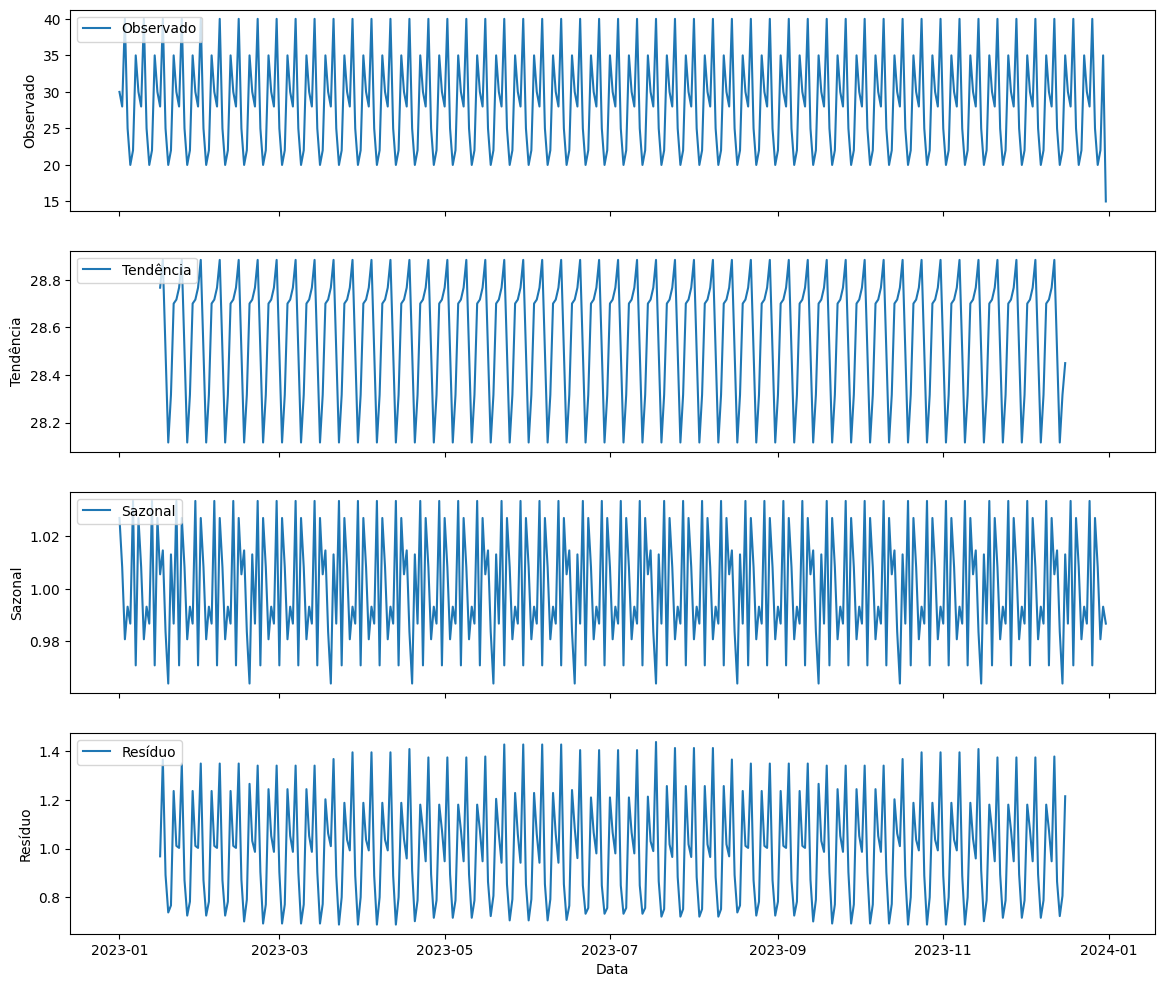

In [45]:
#decomposição sazonal
result = seasonal_decompose(data['Vendas'], model='multiplicative', period=30)

#decomposição
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

ax1.plot(result.observed, label='Observado')
ax1.legend(loc='upper left')
ax1.set_ylabel('Observado')

ax2.plot(result.trend, label='Tendência')
ax2.legend(loc='upper left')
ax2.set_ylabel('Tendência')

ax3.plot(result.seasonal, label='Sazonal')
ax3.legend(loc='upper left')
ax3.set_ylabel('Sazonal')

ax4.plot(result.resid, label='Resíduo')
ax4.legend(loc='upper left')
ax4.set_ylabel('Resíduo')

plt.xlabel('Data')
plt.show()


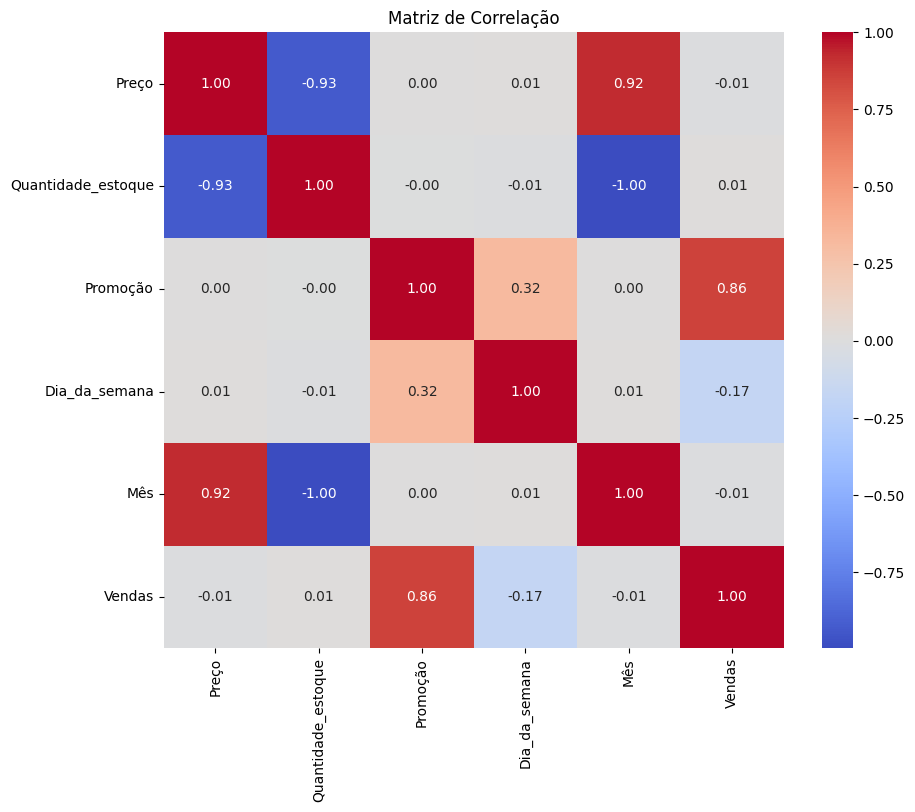

In [46]:
#analise de correlação
#features (caracteristcas) e o target (onde quer chegar / alvo)
plt.figure(figsize=(10, 8))
corr = data[['Preço', 'Quantidade_estoque', 'Promoção', 'Dia_da_semana', 'Mês', 'Vendas']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()


In [47]:
#treino e teste
#preparação dos dados

#features e o target
X = data[['Preço', 'Quantidade_estoque', 'Promoção', 'Dia_da_semana', 'Mês', 'Estação']]
y = data['Vendas']

#variáveis categóricas para dummys
X = pd.get_dummies(X, columns=['Estação', 'Mês'], drop_first=True)


#divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#treinamento do modelo
model = LinearRegression()
model.fit(X_train, y_train)

#avaliação do modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Estimador de Erro: {mse}')

Estimador de Erro: 1.4380103222571183


In [48]:
# Criando um DataFrame com os dados futuros
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
future_data = pd.DataFrame({
    'Data': future_dates,
    'Preço': [12.99] * 30,  # Supondo preço constante
    'Quantidade_estoque': [0] * 30,  # Será previsto
    'Promoção': [0] * 30,  # Sem promoções previstas
    'Dia_da_semana': [i % 7 for i in range(len(data), len(data) + 30)],
    'Mês': [((i // 30) % 12) + 1 for i in range(len(data), len(data) + 30)],
    'Estação': ['Verão'] * 30  # Supondo estação constante
})
future_data.set_index('Data', inplace=True)

# Convertendo variáveis categóricas em variáveis dummy
future_data = pd.get_dummies(future_data, columns=['Estação', 'Mês'], drop_first=True)

# Adicionando colunas faltantes com valor 0 em future_data
missing_cols = set(X_train.columns) - set(future_data.columns)
for col in missing_cols:
    future_data[col] = 0

# Reordenando colunas de future_data para corresponder a X_train
future_data = future_data[X_train.columns]

# Previsão de vendas
future_data['Vendas_Previstas'] = model.predict(future_data)

# Demanda diária média
demanda_diaria_media = future_data['Vendas_Previstas'].mean()
print(f'Demanda Diária Média: {demanda_diaria_media}')

# Estoque de segurança (considerando um desvio padrão da demanda)
estoque_seguranca = future_data['Vendas_Previstas'].std() * 2  # Exemplo: 2 vezes o desvio padrão

# Lead time em dias
lead_time = 7  # Exemplo de 7 dias

# Ponto de reposição
ponto_reposicao = demanda_diaria_media * lead_time + estoque_seguranca
print(f'Ponto de Reposição: {ponto_reposicao}')

Demanda Diária Média: 25.47774679668286
Ponto de Reposição: 184.8578918364311


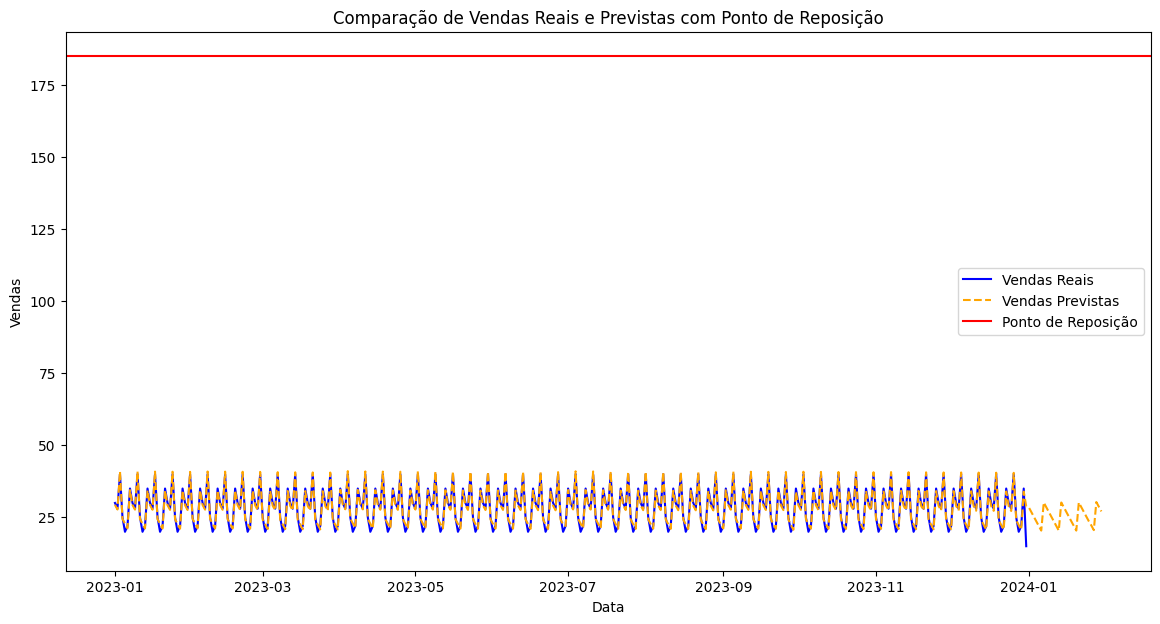

In [49]:
# Adicionando previsões aos dados históricos
data['Vendas_Previstas'] = model.predict(X)
historical_and_forecast = pd.concat([data, future_data[['Vendas_Previstas']]])

# Gráfico de comparação
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Vendas'], label='Vendas Reais', color='blue')
plt.plot(historical_and_forecast.index, historical_and_forecast['Vendas_Previstas'], label='Vendas Previstas', color='orange', linestyle='--')
plt.axhline(y=ponto_reposicao, color='red', linestyle='-', label='Ponto de Reposição')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.title('Comparação de Vendas Reais e Previstas com Ponto de Reposição')
plt.legend()
plt.show()


In [57]:
#ajustando o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

#previsões
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

#resíduos
residuos_train = y_train - y_train_pred
residuos_test = y_test - y_test_pred


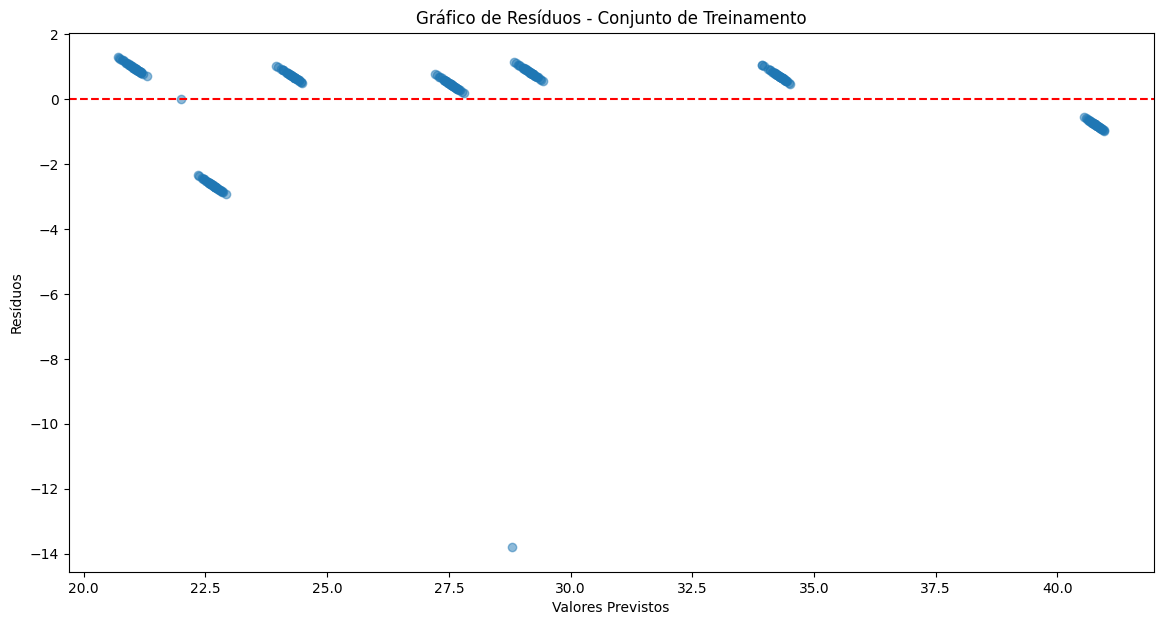

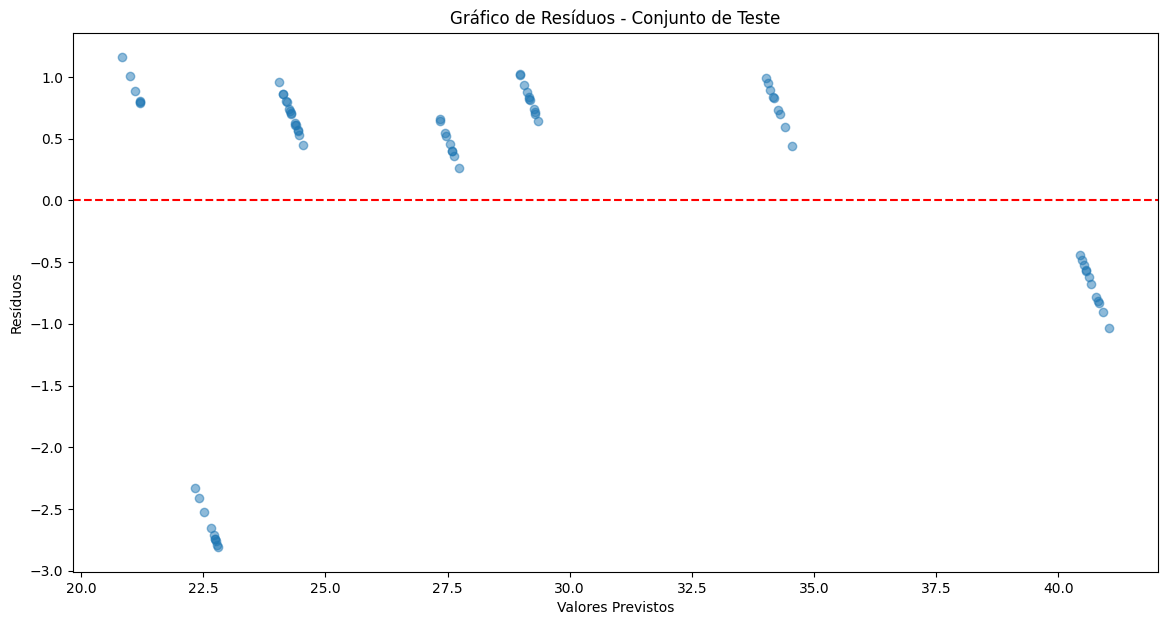

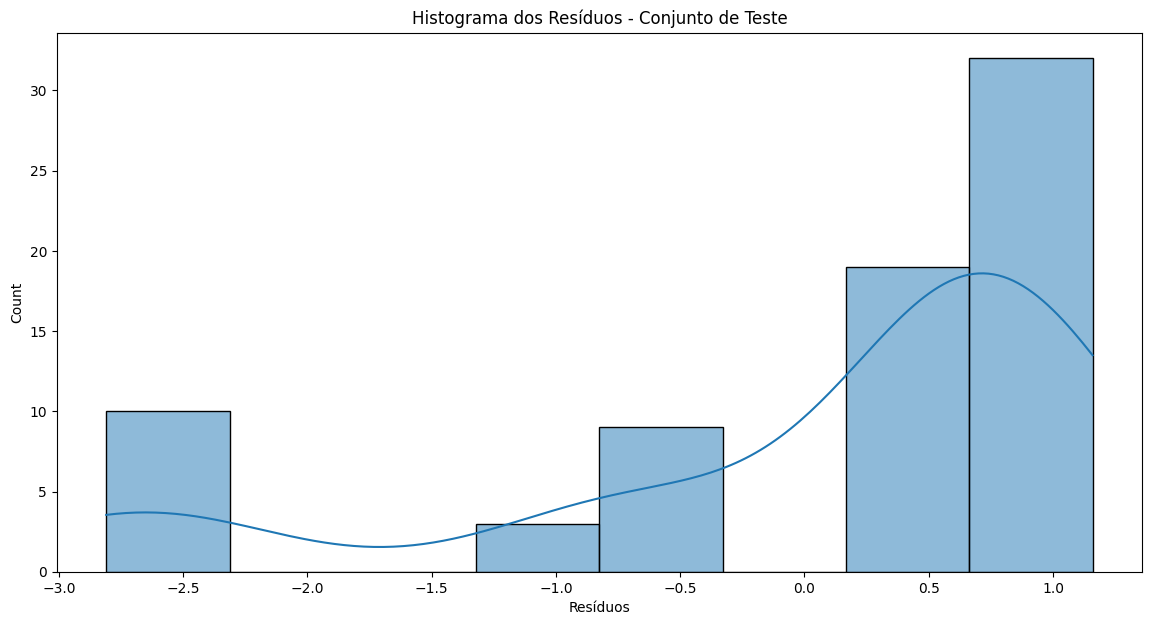

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
plt.scatter(y_train_pred, residuos_train, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos - Conjunto de Treinamento')
plt.show()

plt.figure(figsize=(14, 7))
plt.scatter(y_test_pred, residuos_test, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos - Conjunto de Teste')
plt.show()

plt.figure(figsize=(14, 7))
sns.histplot(residuos_test, kde=True)
plt.xlabel('Resíduos')
plt.title('Histograma dos Resíduos - Conjunto de Teste')
plt.show()


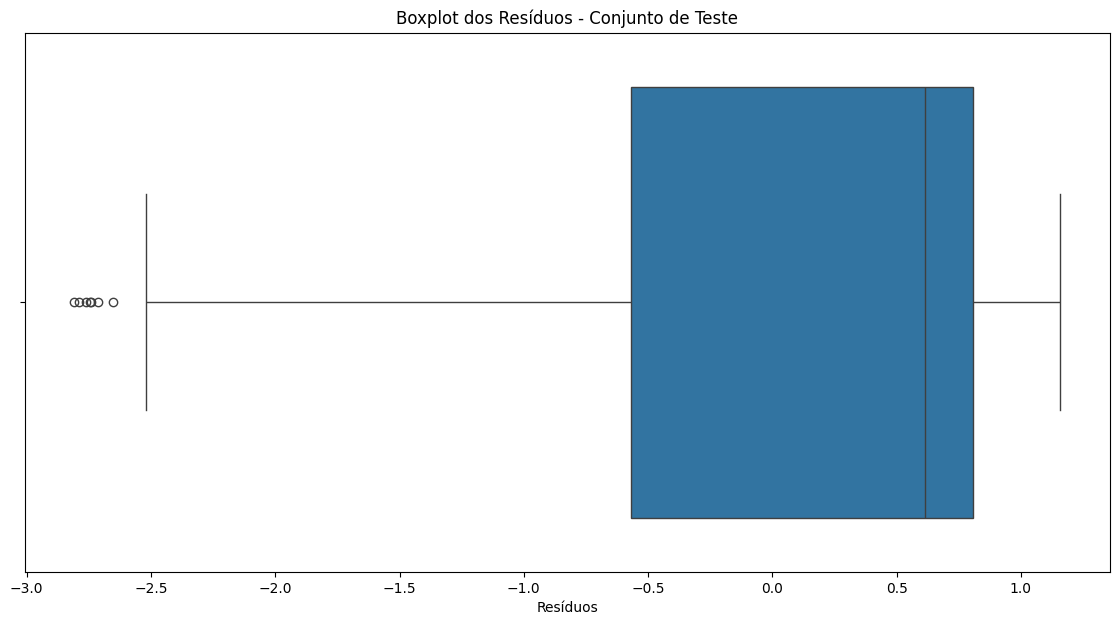

In [59]:
#outliers
plt.figure(figsize=(14, 7))
sns.boxplot(x=residuos_test)
plt.xlabel('Resíduos')
plt.title('Boxplot dos Resíduos - Conjunto de Teste')
plt.show()
